# An overview of gradient descent algorithms

Gradient descent is the standard for optimizing many machine learning algorithms. Here, we explore some of the most popular gradient-based optimization algorithms, such as stochastic gradient descent, Adagrad and Adam. These notes are based on [An overview of gradient descent optimization algorithms by Sebastian Ruder](https://www.ruder.io/optimizing-gradient-descent) and [An updated overview of recent gradient descent algorithms by John Chen](https://johnchenresearch.github.io/demon).

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%load_ext autoreload
%autoreload 2

### Gradient Descent

Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks. More formally, gradient descent is a way to minimize an objective function $E(\mathbf{w})$ parameterized by a model's parameters $\mathbf{w}\in\mathbb{R}^D$ by updating the parameters in the opposite direction of the gradient of the objective function $\nabla E(\mathbf{w})$ w.r.t. to the parameters. The learning rate $\eta$ determines the size of the steps towards reaching the (local) minimum. In other words, it follows the direction of the slope of the surface created by the objective function downhill until it reaches a valley.

The following sections introduce the most popular and interesting variants of gradient descent, provides intuitions towards their behaviour, and presents their motivation to resolve important optimization challenges and how this leads to the derivation of their update rules.

#### Batch vs Mini-batch gradient descent

Vanilla gradient descent or **batch** gradient descent, computes the gradient of the cost function w.r.t. to the parameters for the entire training dataset $\mathbf{X}=[\mathbf{x}_1,\dots,\mathbf{x}_N]^T$, and thus it can be very slow or even intractable for very large datasets that do not fit in memory. Moreover, batch gradient descent does not allow us to update models online, as data stream-in. In contrast, stochastic gradient descent (SGD), usually refers to the paradigm where parameter updates are performed for each single training example $\mathbf{x}_i$. Thus, SGD performs frequent updates having a high variance that cause the objective function to fluctuate heavily. These fluctuations enables SGD to jump to potentially better local minima, but, it also complicates convergence to the exact minimum, since SGD is keep overshooting. However, it has been shown that when we slowly decrease the learning rate, SGD shows the same convergence behaviour as batch gradient descent.

Mini-batch gradient descent takes the best of both worlds and performs an update for every mini-batch of $n$ training examples,

$$
\mathbf{w} = \mathbf{w} - \eta\nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})
$$

This way, it a) reduces the variance of the parameter updates, which leads to more stable convergence; and b) can make use of highly optimized matrix optimizations common to state-of-the-art deep learning libraries that make computing the gradient w.r.t. a mini-batch very efficient. Usually mini-batch sizes vary between $32$ and $512$, but can vary for different applications, depending on the number of features and the size of the network. Mini-batch gradient descent is typically the algorithm of choice when training a neural network and the term SGD is also employed when mini-batches are used.

In order to understand the effect batch size, consider the function $f(x_1, x_2) = x_1 + x_2 + \sin(x_2)$. Lets assume that a random sample have been drawn from $f$ as a training set $\mathbf{X}, \mathbf{y}$. Then, using the sum of squared error as an objective function, the figures below depict the contours of $f$ and the parameter space defined by the error function.

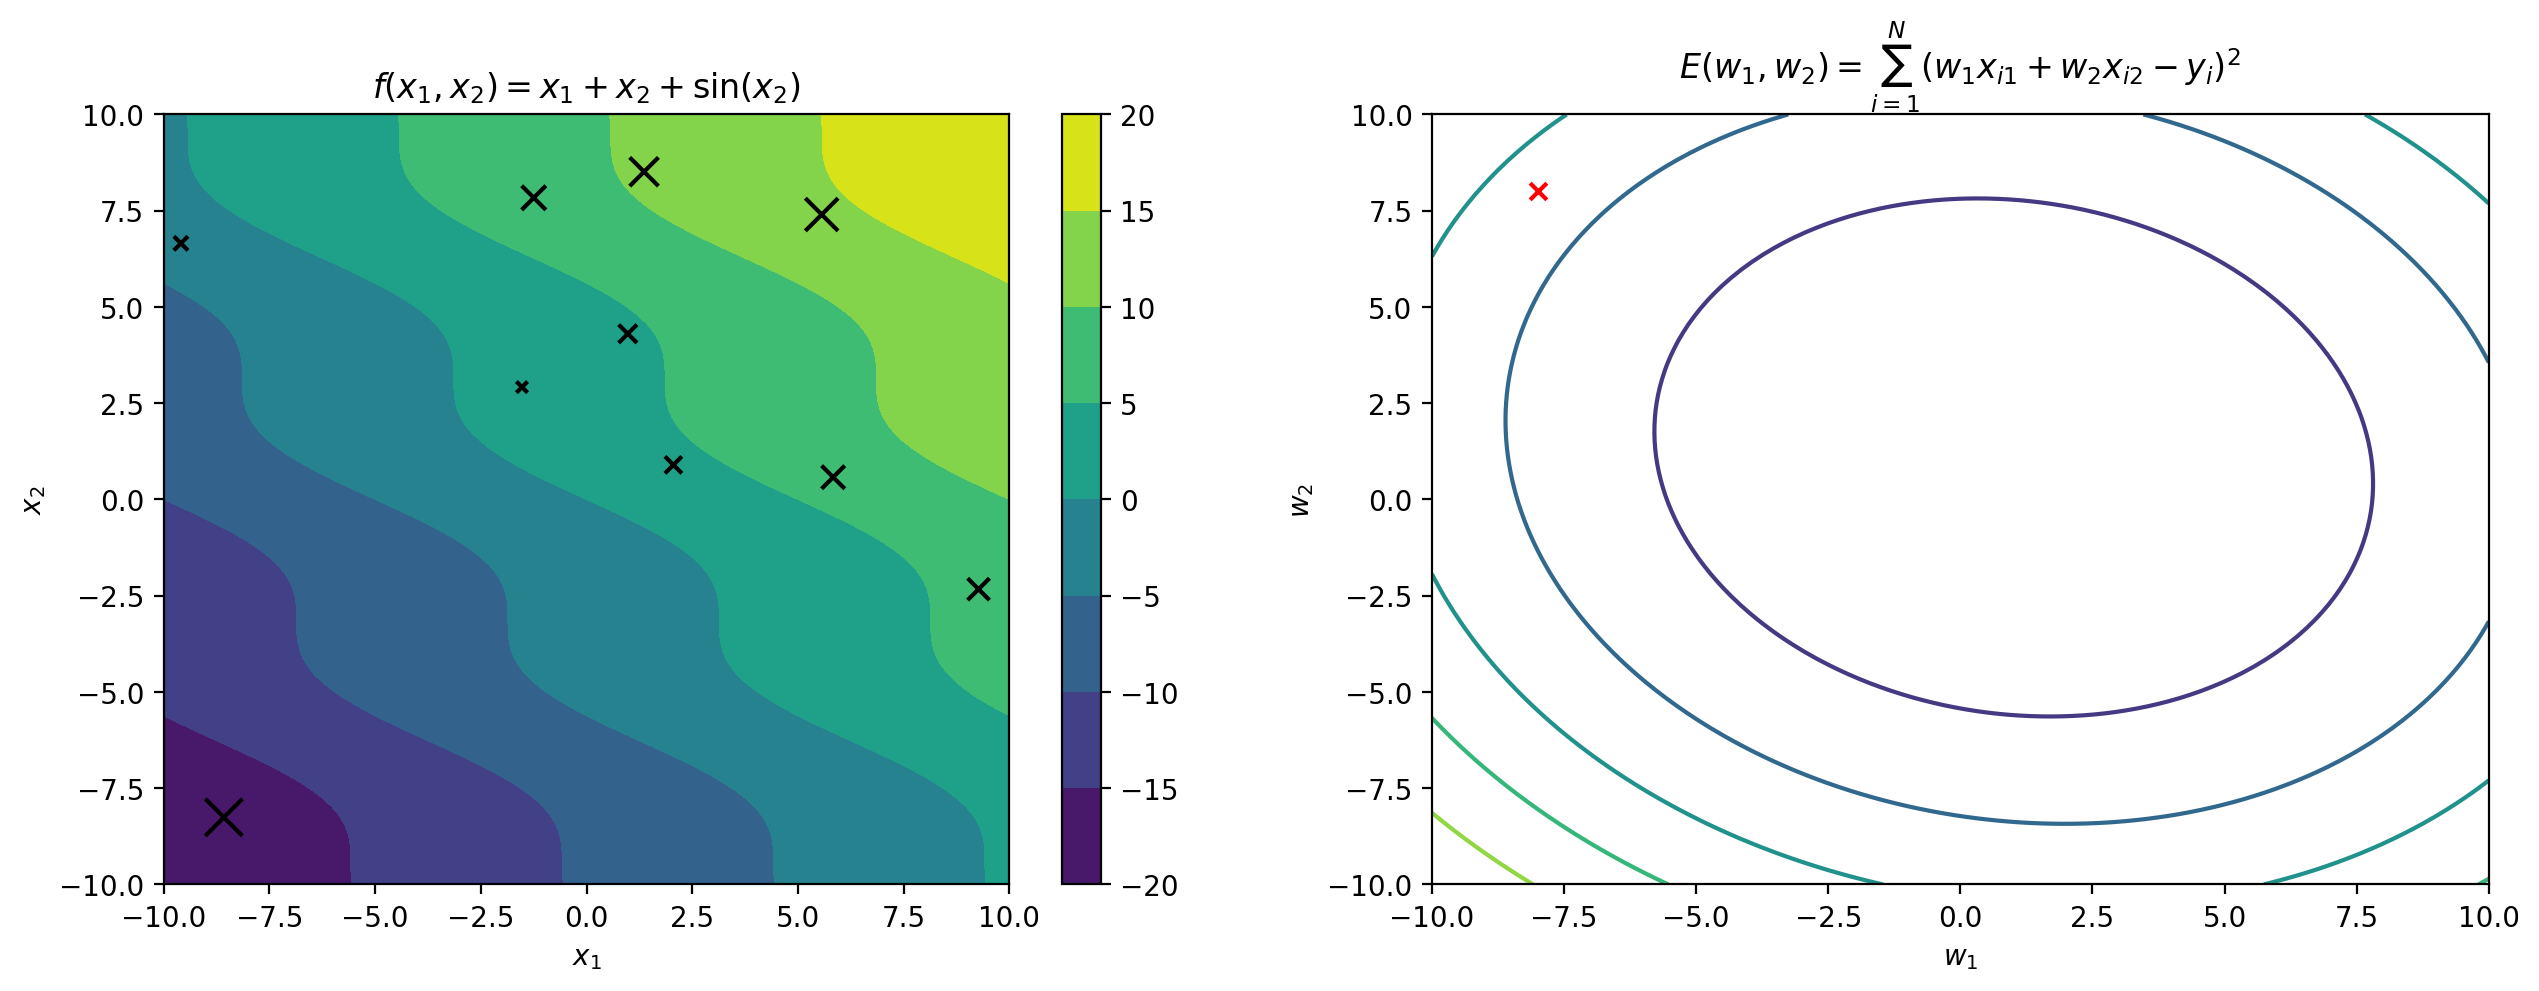

In [4]:
x = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x, x)

f = lambda x1, x2: x1 + x2 + np.sin(x2)

x_sample = np.random.uniform(-10, 10, (10, 2))
y_sample = f(x_sample[:, 0], x_sample[:, 1])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.contourf(x1, x2, f(x1, x2))
plt.colorbar()
plt.scatter(x_sample[:, 0], x_sample[:, 1], np.abs(y_sample * 10), color="black", marker="x")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("$f(x_1, x_2) = x_1 + x_2 + \sin(x_2)$")

w_init = np.array([-8, 8])
w = np.linspace(-10, 10, 100)
w1, w2 = np.meshgrid(w, w)

error = np.sum(
    (w1.reshape(-1, 1) * x_sample[:, 0] + w2.reshape(-1, 1) * x_sample[:, 1] - y_sample) ** 2, axis=1
).reshape(100, 100)

plt.subplot(1, 2, 2)
plt.contour(w1, w2, error)
plt.scatter(*w_init, color="red", marker="x")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("$E(w_1, w_2) = \sum_{i=1}^N (w_1x_{i1} + w_2x_{i2} - y_i)^2$")

plt.show()

Then, given a starting point in the error function (depicted by the red cross), gradient descent incrementally moves towards the optimal solution, since the error function is convex. However, keep in mind, that in a neural network the error function is **non-convex** and thus, there are multiple local optima. The following figures present the path followed by the batch gradient descent, SDG and mini-batch SDG to arrive to the optima of the sum of squared error function.

Batch gradient descent seems to move directly towards the optimal solution without fluctuations. However, since it requires the entire dataset to be loaded in memory it may become slow as the training dataset size increases. In a toy dataset, there is no such issue of course, but in real-world problems the issue is very common. On the other hand, SGD processes one example in every iteration, making training efficient in terms of memory, but there are fluctuations across iterations. Mini-batch gradient descent lies in-between. It does not fluctuate a lot across iterations, and it operates in a online fashion using a batch of data per iteration instead, thus avoiding memory problems. Moreover, mini-batch gradient descent is also much more efficient than SDG because it gains significant speedups from vectorization operations.

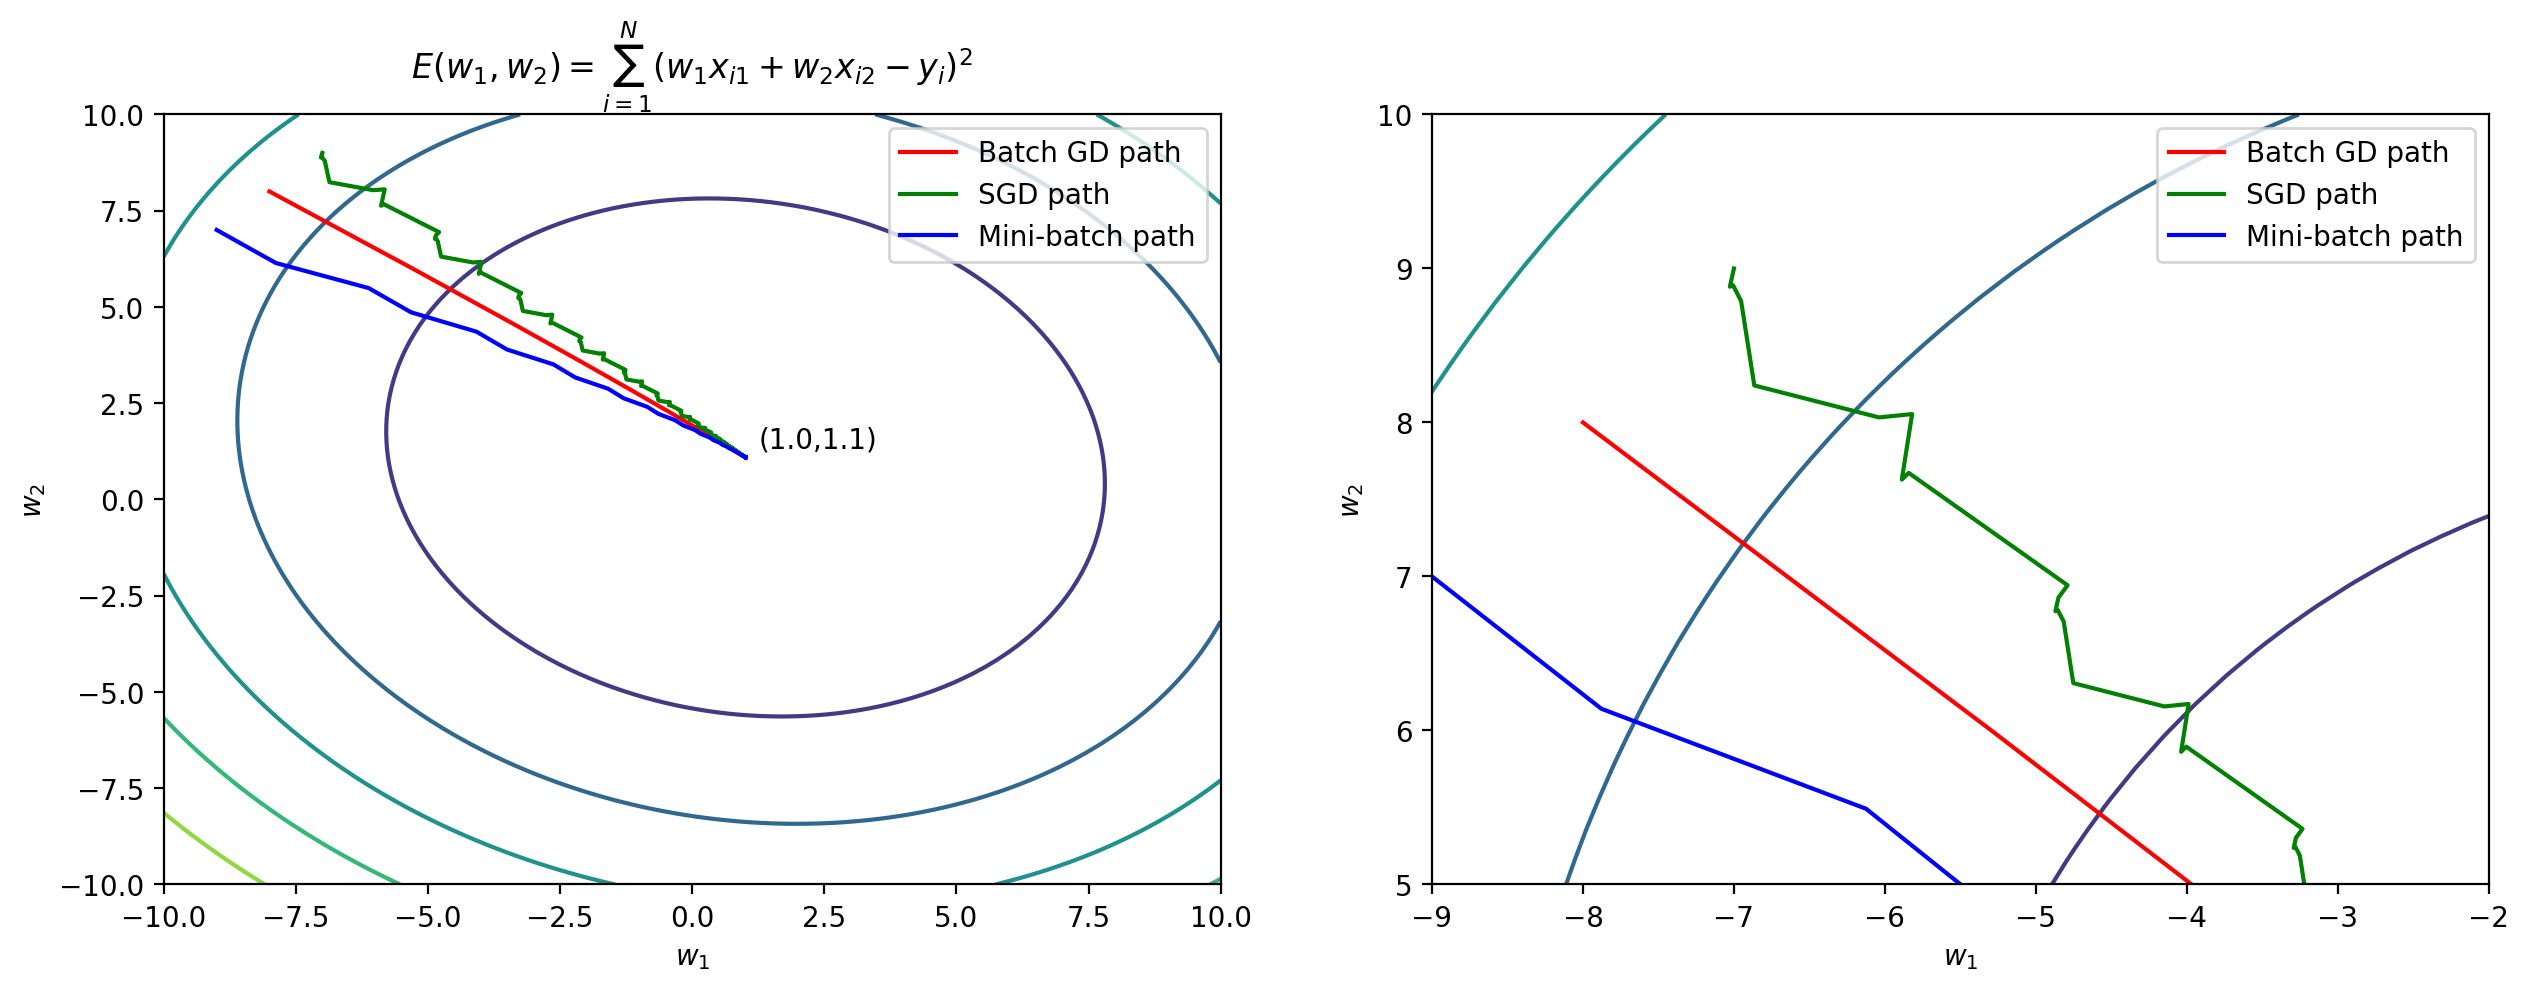

In [5]:
def error_gradient(w1, w2, x, y):
    if x.ndim == 1:
        return np.array([(w1 * x[0] + w2 * x[1] - y) * x[0], (w1 * x[0] + w2 * x[1] - y) * x[1]]).T
    else:
        return np.array(
            [(w1 * x[:, 0] + w2 * x[:, 1] - y) * x[:, 0], (w1 * x[:, 0] + w2 * x[:, 1] - y) * x[:, 1]]
        ).T.sum(axis=0)


n_epochs = 1000
learning_rate = 0.001
batch_gd_path, sgd_path, mini_batch_gd = [w_init], [w_init + 1], [w_init - 1]

# batch gradient descent
w_optimal = batch_gd_path[0]
for _ in range(n_epochs):
    w_optimal = w_optimal - learning_rate * error_gradient(w_optimal[0], w_optimal[1], x_sample, y_sample)
    batch_gd_path.append(w_optimal)

# stochastic gradient descent
w_optimal = sgd_path[0]
for _ in range(n_epochs):
    for i in range(x_sample.shape[0]):
        w_optimal = w_optimal - learning_rate * error_gradient(w_optimal[0], w_optimal[1], x_sample[i, :], y_sample[i])
        sgd_path.append(w_optimal)

# mini-batch gradient descent
w_optimal = mini_batch_gd[0]
mini_batches_x = np.split(x_sample, 2)
mini_batches_y = np.split(y_sample, 2)
for _ in range(n_epochs):
    for i in range(len(mini_batches_x)):
        w_optimal = w_optimal - learning_rate * error_gradient(
            w_optimal[0], w_optimal[1], mini_batches_x[i], mini_batches_y[i]
        )
        mini_batch_gd.append(w_optimal)

batch_gd_path = np.array(batch_gd_path)
sgd_path = np.array(sgd_path)
mini_batch_gd = np.array(mini_batch_gd)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.contour(w1, w2, error)
plt.plot(batch_gd_path[:, 0], batch_gd_path[:, 1], color="r", markersize=3)
plt.plot(sgd_path[:, 0], sgd_path[:, 1], color="g")
plt.plot(mini_batch_gd[:, 0], mini_batch_gd[:, 1], color="b")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("$E(w_1, w_2) = \sum_{i=1}^N (w_1x_{i1} + w_2x_{i2} - y_i)^2$")
plt.legend(["Batch GD path", "SGD path", "Mini-batch path"])
plt.annotate(
    text=f"({round(batch_gd_path[-1][0], 1)},{round(batch_gd_path[-1][1], 1)})",
    xy=batch_gd_path[-1],
    xytext=batch_gd_path[-1] + 0.25,
)

plt.subplot(1, 2, 2)
plt.contour(w1, w2, error)
plt.plot(batch_gd_path[:, 0], batch_gd_path[:, 1], color="r", markersize=3)
plt.plot(sgd_path[:, 0], sgd_path[:, 1], color="g")
plt.plot(mini_batch_gd[:, 0], mini_batch_gd[:, 1], color="b")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.legend(["Batch GD path", "SGD path", "Mini-batch path"])
plt.xlim(-9, -2)
plt.ylim(5, 10)

plt.show()

##### Challenges

1. Choosing a proper learning rate can be cumbersome. A learning rate that is too small leads slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.

2. Learning rate schedules try to adjust the learning rate during training by e.g., annealing, that is, reducing the learning rate according to a pre-defined schedule or when the change in objective between epochs falls below a threshold. These schedules and thresholds, however, have to be determined in advance and are unable to adapt to dataset's characteristics.

3. Learning rate applies horizontally to all parameter updates. If the data is sparse and the features have very different frequencies, we might not want to update all of them to the same extent, but instead, perform larger updates for rarely occurring features.

4. Another key challenge of minimizing highly non-convex error functions, which is common for neural networks, is avoiding getting trapped in their numerous suboptimal local minima. This difficulty arises from saddle points, i.e., points where one dimension slopes up and another slopes down (see the following figure). These saddle points are usually surrounded by a plateau of the same error, which makes it notoriously hard for SGD to escape, as the gradient is close to zero in all dimensions.

<Figure size 640x480 with 0 Axes>

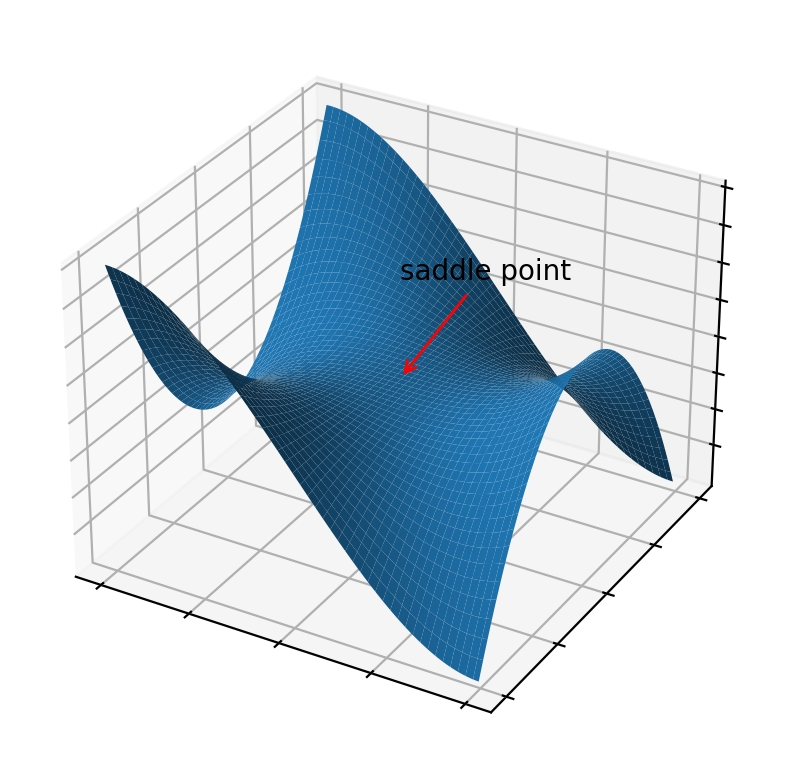

In [6]:
X1, X2 = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
Z = X1**3 - 3 * X1 * X2**2

fig = plt.figure()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X1, X2, Z)
ax.annotate("saddle point", (0, 0), (0, 0.025), arrowprops=dict(arrowstyle="->", color="red"))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
plt.show()

#### Exponential Moving Average

Before diving into momentum, lets take a moment to examine exponential moving average. The general equations for exponential moving average are as follows,

$$
\begin{align*}
u_0 &= 0\\
u_t &= \beta u_{t-1} + (1-\beta) \theta_t
\end{align*}
$$

where parameter $\beta$ controls the smoothing effect, that is, as the value of $\beta$ increases, the resulting average curve becomes smoother. Intuitively, $u_t$ is approximetely the average over $\frac{1}{1-\beta}$ days. For instance, if $\beta=0.9$ then the average is an approximation over $10$ days. By recursively applying the $u_t$ formula to itself, $u_t$ results in a summation of weighted $\theta$ terms, as follows,

$$
\begin{align*}
u_t &= \beta u_{t-1} + (1-\beta) \theta_t \Leftrightarrow \\
u_t &= \beta (\beta u_{t-2} + (1-\beta) \theta_{t-1}) + (1-\beta) \theta_t \Leftrightarrow \\
u_t &= \beta^2 u_{t-2} + (1-\beta)\beta \theta_{t-1} + (1-\beta) \theta_t \Leftrightarrow \\
u_t &= \beta^3 u_{t-3} + (1-\beta)\beta^2 \theta_{t-2} + (1-\beta)\beta \theta_{t-1} + (1-\beta) \theta_t \Leftrightarrow \\
& \cdots \\
u_t &= \beta^{t+1} u_0 + (1-\beta)\beta^t \theta_1 + \cdots + (1-\beta)\beta^2 \theta_{t-2} + (1-\beta)\beta \theta_{t-1} + (1-\beta) \theta_t
\end{align*}
$$

Thus, $u_t$ is a summation over past values, weighted by exponential versions of $\beta$. Since $\beta < 1$, as $t$ increases, past values contribute increasigly less to the summation, leading to a form of exponential averaging. Given a dataset of observations across time (time-series), exponential moving average helps smooth the trajectory of these observations and reduce noise. For instance consider the following scatter of daily temperature readings from year 2011 in the city of Athens, Greece. Note that the exponential moving average (using $\beta=0.9$) of the readings gives a smoother form.

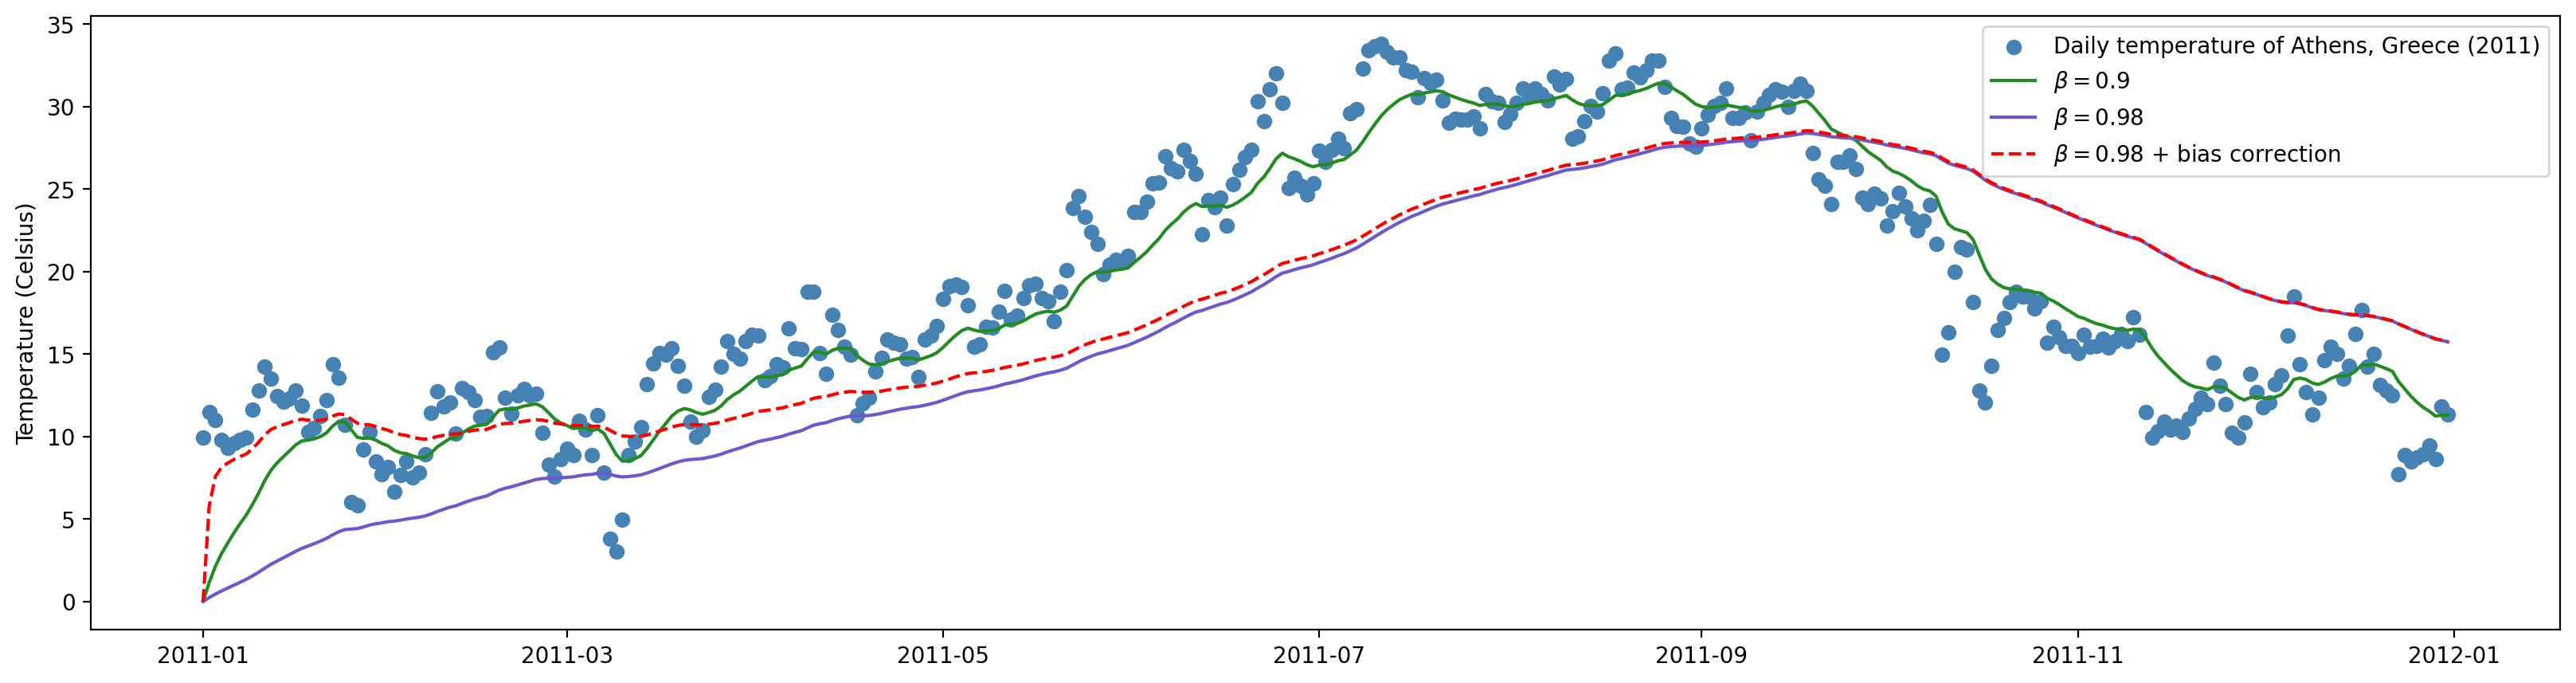

In [7]:
import pandas as pd

df = pd.read_csv("../datasets/athens_temperature.csv", parse_dates=[0], dayfirst=True)
df = df[df["date"].dt.year == 2011]


def exponential_smoothing(x, beta: float, bias_correction: bool = False):
    y = [0]
    for i in range(1, len(x)):
        y.append(beta * y[i - 1] + (1 - beta) * x.iloc[i])
    return [yi / (1 - beta ** (i + 1)) for i, yi in enumerate(y)] if bias_correction else y


plt.figure(figsize=(20, 5))
plt.scatter(df["date"], df["avg_temperature"], color="steelblue")
plt.plot(df["date"], exponential_smoothing(df["avg_temperature"], 0.9), color="forestgreen")
plt.plot(df["date"], exponential_smoothing(df["avg_temperature"], 0.98), color="slateblue")
plt.plot(df["date"], exponential_smoothing(df["avg_temperature"], 0.98, True), color="red", linestyle="--")
plt.legend(
    ["Daily temperature of Athens, Greece (2011)", "$\\beta=0.9$", "$\\beta=0.98$", "$\\beta=0.98$ + bias correction"]
)
plt.ylabel("Temperature (Celsius)")
plt.show()

Finally, as depicted in the figure above, to account for bias introduced by the starting value $u_0$, divide $v_t$ by $1 - \beta^t$. Otherwise, exponential smoothing requires some time to warm up, analogous to the choice of $\beta$. 

#### Momentum

SGD has trouble navigating areas where the surface curves much more steeply in one dimension than in another, which are common around local optima and saddle points. In these scenarios, SGD oscillates across the slopes of the area while only making hesitant progress along the bottom towards the local optimum. *Momentum* is a method that helps accelerate SGD in the relevant direction and dampens oscillations. Essentially, it uses exponential moving average over the gradient path by adding adding a fraction $\beta$ of the update vector of the past update step to the current update vector as follows,

$$
\begin{aligned}
\mathbf{u}_{\tau} &= \beta\mathbf{u}_{\tau-1} + (1 - \beta)\nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})\\
\mathbf{w} &= \mathbf{w} - \eta\mathbf{u}_{\tau}
\end{aligned}
$$

where the momentum term $\beta$ is usually set to $0.9$ or a similar value. Intuitively, when using momentum, we push a ball down the hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way. The parameter $\beta < 1$ plays the role of air resistance. The same thing happens to our parameter updates. The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.

This can be seen by applying momentum to stochastic gradient descent (SGD), as depicted in the next figure. Momentum aids SGD to attain similar behavior to batch gradient descent. Moreover, note that it oscillates less than the mini-batch version. However, the combination of mini-batch gradient descent and momentum achieves similar results and is more on large datasets, due to vectorization.

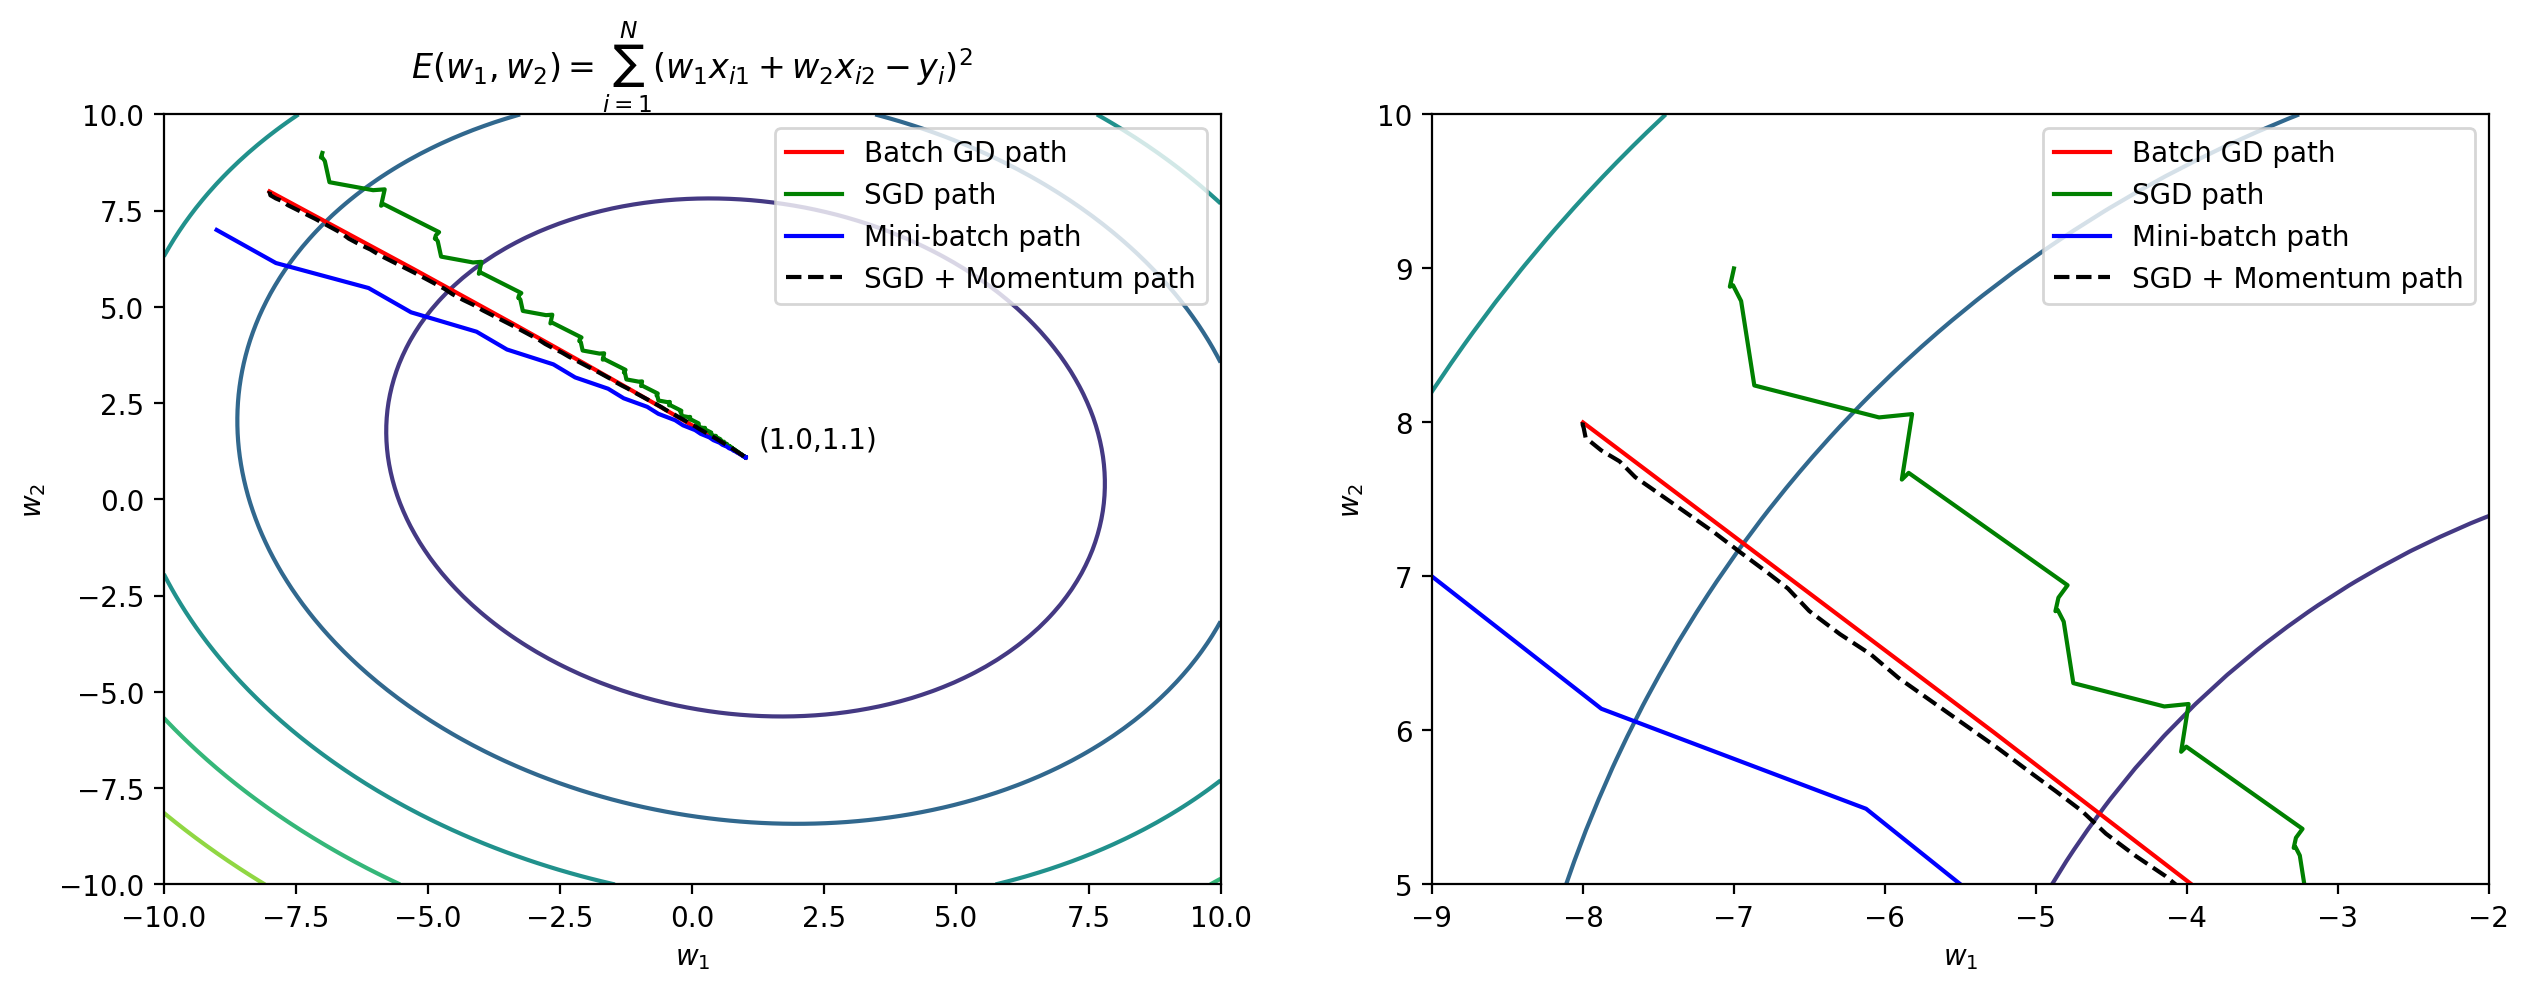

In [26]:
beta = 0.9
momentum_gd_path = [w_init]
momentum_mini_batch_gd = [w_init]

# momentum stochastic gradient descent
u = 0
w_optimal = momentum_gd_path[0]
mini_batches_x = np.split(x_sample, 2)
mini_batches_y = np.split(y_sample, 2)
for _ in range(n_epochs):
    for i in range(x_sample.shape[0]):
        u = beta * u + (1 - beta) * error_gradient(w_optimal[0], w_optimal[1], x_sample[i, :], y_sample[i])
        w_optimal = w_optimal - learning_rate * u
        momentum_gd_path.append(w_optimal)

momentum_gd_path = np.array(momentum_gd_path)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.contour(w1, w2, error)
plt.plot(batch_gd_path[:, 0], batch_gd_path[:, 1], color="r")
plt.plot(sgd_path[:, 0], sgd_path[:, 1], color="g")
plt.plot(mini_batch_gd[:, 0], mini_batch_gd[:, 1], color="b")
plt.plot(momentum_gd_path[:, 0], momentum_gd_path[:, 1], color="k", linestyle="--")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("$E(w_1, w_2) = \sum_{i=1}^N (w_1x_{i1} + w_2x_{i2} - y_i)^2$")
plt.legend(["Batch GD path", "SGD path", "Mini-batch path", "SGD + Momentum path"])
plt.annotate(
    text=f"({round(batch_gd_path[-1][0], 1)},{round(batch_gd_path[-1][1], 1)})",
    xy=batch_gd_path[-1],
    xytext=batch_gd_path[-1] + 0.25,
)

plt.subplot(1, 2, 2)
plt.contour(w1, w2, error)
plt.plot(batch_gd_path[:, 0], batch_gd_path[:, 1], color="r")
plt.plot(sgd_path[:, 0], sgd_path[:, 1], color="g")
plt.plot(mini_batch_gd[:, 0], mini_batch_gd[:, 1], color="b")
plt.plot(momentum_gd_path[:, 0], momentum_gd_path[:, 1], color="k", linestyle="--")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.legend(["Batch GD path", "SGD path", "Mini-batch path", "SGD + Momentum path"])
plt.xlim(-9, -2)
plt.ylim(5, 10)

plt.show()

### Adaptive Learning Rates

Apart from adapting the updates to the slope of the error function in order to speed up SGD, in turn, it is also valuable to adapt SDG updates to each individual parameter and perform larger or smaller updates depending on their importance.

#### Adagrad

Adagrad is an algorithm that adapts the learning rate to the parameters, performing smaller updates (i.e., low learning rates) for parameters associated with frequently occurring features, and larger updates (i.e., high learning rates) for parameters associated with infrequent features. To that end, it is well-suited for dealing with sparse data. Typical gradient descent performs an update for all parameters $\mathbf{w}$ at once, as every parameter $w_i$ uses the same learning rate $\eta$. On the other hand, Adagrad uses a different learning rate for every parameter $w_i$ at every time step $\tau$. For brevity, $\mathbf{g}_{\tau}$ denotes the gradient vector at time step $\tau$ and $g_{i,\tau}$ denotes the partial derivative of the objective function over the parameter $w_i$ at time step $\tau$,

$$
\mathbf{g}_{\tau} = \nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})
$$

and

$$
g_{i,\tau} = \frac{\partial E(w_i;\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})}{\partial w_i}
$$

Adagrad modifies the general learning rate $\eta$ at each time step $\tau$ for every parameter $w_i$ based on the past gradients that have been computed for $w_i$ as follows,

$$
w_{i,\tau} = w_{i,\tau-1} − \frac{\eta}{\sqrt{G_{ii,\tau-1} + \epsilon}} g_{i,\tau-1}
$$

where $\mathbf{G}_{\tau} \in \mathbb{R}^{D \times D}$ is a diagonal matrix and each diagonal element is the sum of the squares of the gradients of $w_i$ up to time step $\tau$, while $\epsilon$ is a smoothing term that avoids division by zero, typically on the order of $10^{−8}$. Interestingly, without the square root operation, the algorithm performs much worse. As $\mathbf{G}_{\tau}$ contains the sum of the squares of the past gradients for all parameters along its diagonal, the implementation can be vectorized by performing a Hadamard product between $\mathbf{G}_{\tau}$ and $\mathbf{g}_{\tau}$ to obtain,

$$
\begin{aligned}
\mathbf{G}_{\tau} &= \mathbf{G}_{\tau-1} + \mathbf{I} \odot (\mathbf{g}^2_{\tau})^T \\
\mathbf{w}_{\tau+1} &= \mathbf{w}_{\tau} − \frac{\eta}{\sqrt{\mathbf{G}_{\tau} + \epsilon}} \odot \mathbf{g}_{\tau}
\end{aligned}
$$

One of Adagrad's main benefits is that it eliminates the need to manually tune the learning rate $\eta$. On the other hand, Adagrad's main weakness is its accumulation of the squared gradients in the denominator. Since every added term is positive, the accumulated sum keeps growing during training. In turn, the learning rate shrinks and eventually becomes infinitesimally small, at which point the algorithm is no longer able to acquire additional knowledge.

#### Adadelta

Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size $h$. Instead of inefficiently storing $h$ previous squared gradients, the sum of gradients is recursively defined, similar to *Momentum*, as an exponential moving average of all past squared gradients. To avoid confusion I shall use the symbol $\mathbf{s}$ for representing the exponential moving average over the squared gradients. The running average at time step $\tau$ then depends only on the previous average and the current gradient as follows,

$$
\mathbf{s}_{\tau} = \beta \mathbf{s}_{\tau-1} + (1−\beta)\mathbf{g}_{\tau}^2
$$

Similar to the momentum term, $\beta$ is usually set around $0.9$. Then, Adadelta simply replaces the diagonal matrix $\mathbf{G}_{\tau}$ using the decaying average over past squared gradients $u_{\tau}$,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} − \frac{\eta}{\sqrt{\mathbf{s}_{\tau} + \epsilon}} \odot \mathbf{g}_{\tau}
$$

Note that the denominator is just the root mean squared (RMS) criterion of the gradient, and thus,

$$
\begin{aligned}
RMS(\mathbf{g}_{\tau}) &= \sqrt{\mathbf{s}_{\tau} + \epsilon} \\
\mathbf{w}_{\tau+1} &= \mathbf{w}_{\tau} − \frac{\eta}{RMS(\mathbf{g}_{\tau})} \mathbf{g}_{\tau}
\end{aligned}
$$

Note that the units in the update (as well as in SGD, Momentum, or Adagrad) do not match, i.e., the update should have the same hypothetical units as the parameter. To that end, lets define another exponentially decaying average, this time not of squared gradients but of squared parameter updates,

$$
\begin{aligned}
\Delta\mathbf{w}_{\tau} &= − \frac{\eta}{RMS(\mathbf{g}_{\tau})} \mathbf{g}_{\tau} \\
\mathbf{d}_{\tau} &= \gamma\mathbf{d}_{\tau-1} + (1−\gamma)\Delta\mathbf{w}_{\tau}^2
\end{aligned}
$$

Then, the root mean squared error of parameter updates becomes,

$$
RMS(\Delta\mathbf{w}_{\tau}) = \sqrt{\mathbf{d}_{\tau} + \epsilon}
$$

Since $RMS(\Delta\mathbf{w}_{\tau})$ is unknown, the RMS of parameter updates until the previous time step is used as an approximation. Replacing the learning rate $\eta$ in the previous update rule with $RMS(\Delta\mathbf{w}_{\tau-1})$ yields the final Adadelta update rule,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \frac{RMS(\Delta\mathbf{w}_{\tau-1})}{RMS(\mathbf{g}_{\tau})} \mathbf{g}_{\tau}
$$

Note that Adadelta does not even require to set a default learning rate $\eta$, as it has been eliminated from the update rule.

#### RMSprop

RMSprop is another adaptive learning rate method developed around the same time with Adadelta, stemming from the need to resolve Adagrad's radically diminishing learning rates. RMSprop in fact is identical to the first update vector of Adadelta derived above,

$$
\begin{aligned}
\mathbf{s}_{\tau} &= \beta \mathbf{s}_{\tau-1} + (1 - \beta)\nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})^2\\
\mathbf{w}_{\tau+1} &= \mathbf{w}_{\tau} - \frac{\eta}{\sqrt{\mathbf{s}_{\tau} + \epsilon}}\nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})
\end{aligned}
$$

RMSprop also divides the learning rate by an exponentially decaying average of squared gradients. Intuitively, the squares help overstate larger/smaller derivatives, thus overstate steeper areas of the curve, while understate flatten areas, leading to faster learning.

#### Adam

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients $\mathbf{s}_{\tau}$, like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients $\mathbf{u}_{\tau}$, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, and thus prefers flat minima in the error surface. We compute the decaying averages of past and past squared gradients $\mathbf{u}_{\tau}$ and $\mathbf{s}_{\tau}$ respectively as follows,

$$
\begin{aligned}
\mathbf{u}_{\tau} &= \beta_1\mathbf{u}_{\tau-1} + (1−\beta_1)\mathbf{g}_{\tau} \\
\mathbf{s}_{\tau} &= \beta_2\mathbf{s}_{\tau-1} + (1−\beta_2)\mathbf{g}_{\tau}^2
\end{aligned}
$$

$\mathbf{u}_{\tau}$ and $\mathbf{s}_{\tau}$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method. As $\mathbf{u}_{\tau}$ and $\mathbf{s}_{\tau}$ are initialized as vectors of zeros, they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small (i.e. $\beta_1$ and $\beta_2$ are close to $1$). These biases may be counteracted by computing the bias-corrected first and second moment estimates as follows,

$$
\begin{aligned}
\mathbf{\hat{u}}_{\tau} &= \frac{\mathbf{u}_{\tau}}{1 − \beta_1} \\
\mathbf{\hat{s}}_{\tau} &= \frac{\mathbf{s}_{\tau}}{1 − \beta_2}
\end{aligned}
$$

Then use these bias-corrected values to update the parameters just as we have seen in Adadelta and RMSprop, which yields the Adam update rule:

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \frac{\eta}{\sqrt{\mathbf{\hat{s}}_{\tau} + \epsilon}}\mathbf{\hat{u}}_{\tau}
$$

Sane default values for the hyperparameters are $\beta_1=0.9$, $\beta_2=0.99$ and $\epsilon=10^{−8}$.

#### AdamW

Weight decay (quadratic regularizer) is usually implemented by adding a term to the error function (see [Chapter 5](ch5_neural_networks.ipynb) for Neural Networks). AdamW modifies the typical implementation of weight decay regularization in Adam, by decoupling the weight decay from the gradient update,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \eta\Big( \frac{1}{\sqrt{\mathbf{\hat{s}}_{\tau} + \epsilon}}\mathbf{\hat{u}}_{\tau} + \lambda\mathbf{w}_{\tau} \Big)
$$

It turns out that this detail makes a difference in practice and has been adopted by the machine learning community.

### Optimizing Beale's function

There are many [test functions](https://en.wikipedia.org/wiki/Test_functions_for_optimization) that are useful for evaluating optimization algorithms. In particular, we shall look at Beale's function:

$$
f(x,y) = (1.5 − x + xy)^2 + (2.25 − x + xy^2)^2 + (2.625 − x + xy^3)^2
$$

$$
\nabla f(x,y) = 
\begin{bmatrix}
2 x (y^6 + y^4 - 2 y^3 - y^2 - 2 y + 3) + 5.25 y^3 + 4.5 y^2 + 3 y - 12.75 \\
6 x (x (y^5 + 0.666667 y^3 - y^2 - 0.333333 y - 0.333333) + 2.625 y^2 + 1.5 y + 0.5)
\end{bmatrix}
$$

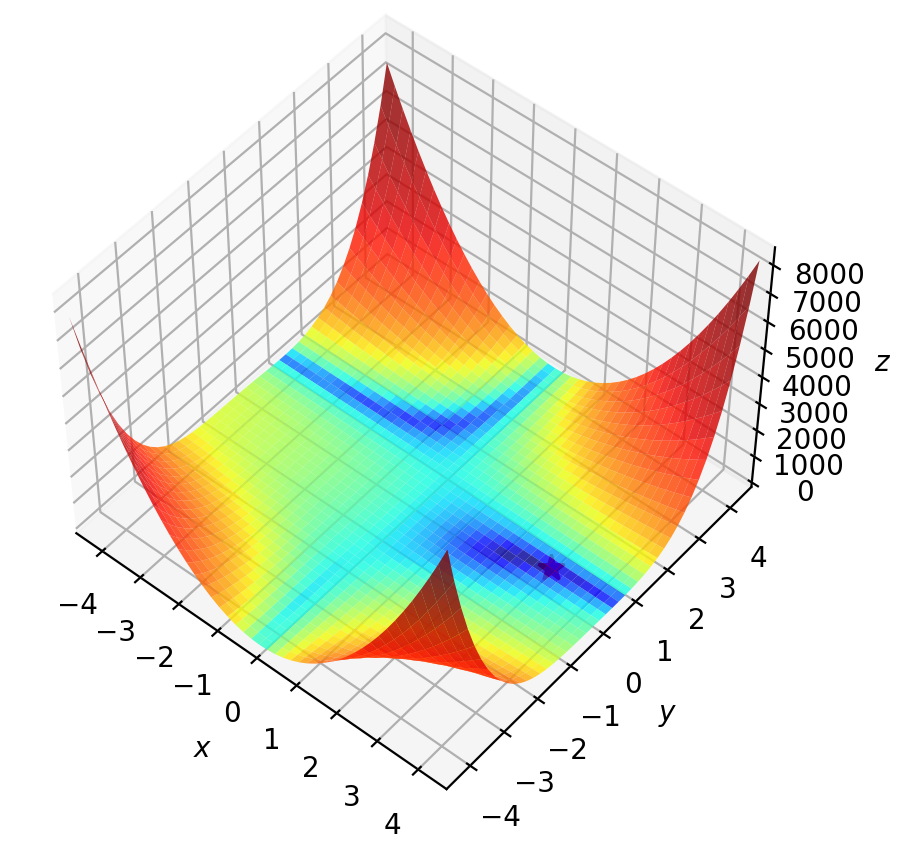

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

f = lambda x, y: (1.5 - x + x * y) ** 2 + (2.25 - x + x * y**2) ** 2

xmin, xmax, xstep = -4.5, 4.5, 0.2
ymin, ymax, ystep = -4.5, 4.5, 0.2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

z = f(x, y)
minima = np.array([3.0, 0.5])
minima_ = minima.reshape(-1, 1)
minima_

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection="3d", elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor="none", alpha=0.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), "ko", markersize=10)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

(-4.5, 4.5)

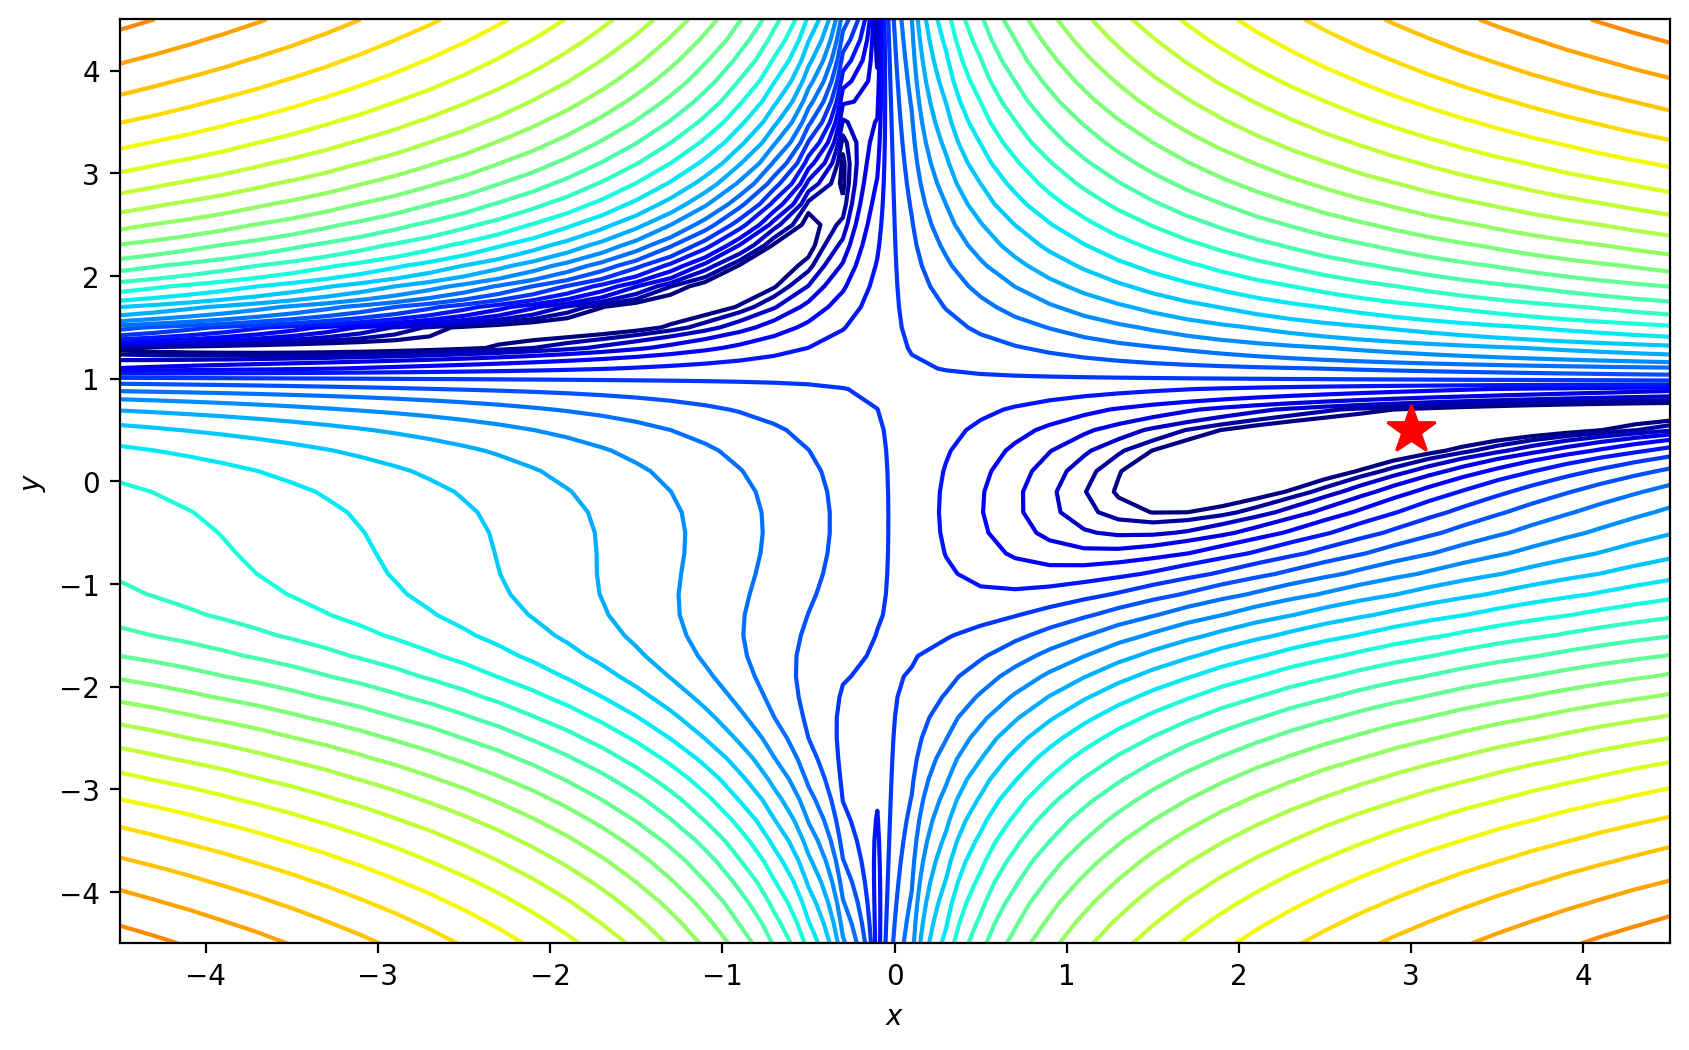

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
# ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, "r*", markersize=18)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

#### Which optimizer to use?

When the input data is sparse, then adaptive learning-rate methods are likely to achieve the best results. In addition, these methods do not require tuning on the learning rate and they often achieve the best results using the default value.

RMSprop avoids the radically diminishing learning rates Adagrad. It is identical to Adadelta, except that Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, adds bias-correction and momentum to RMSprop. Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that perform equally good in similar circumstances. Bias-correction usually helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser, and thus, Adam might be the best overall choice.

Vanilla SGD and a simple learning rate annealing schedule finds a minimum but it might take significantly longer than. SGD is much more reliant on robust initialization and annealing schedule, and may get stuck in saddle points rather than local minima. Consequently, if you care about fast convergence, you should choose one of the adaptive learning rate methods.

### Adam variants and other improvements

#### AdaMax

The $\mathbf{s}_{\tau}$ factor in the Adam update rule scales the gradient inversely proportionally to the $\ell_2$ norm of the past gradients (via the $\mathbf{s}_{\tau-1}$ term) and current gradient $\mathbf{g}_{\tau}^2$,

$$
\mathbf{s}_{\tau} = \beta_2\mathbf{s}_{\tau-1} + (1-\beta_2)\mathbf{g}_{\tau}^2
$$

The update rule can be generalized to the $\ell_p$ norm,

$$
\mathbf{s}_{\tau} = \beta_2^p\mathbf{s}_{\tau-1} + (1-\beta_2^p)|\mathbf{g}_{\tau}|^p
$$

Norms for large $p$ values generally become numerically unstable, making the $\ell_1$ and $\ell_2$ norms the most common in practice. However, $\ell_{\infty}$ norm generally exhibits stable behavior. To that end, it can be shown using $\ell_{\infty}$ converges to the following more stable value,

$$
\mathbf{i}_{\tau} = \beta_2^{\infty}\mathbf{i}_{\tau-1} + (1-\beta_2^{\infty})|\mathbf{g}_{\tau}|^{\infty} = \max(\beta_2\mathbf{i}_{\tau-1}, |\mathbf{g}_{\tau}|)
$$

Then, by replacing $\sqrt{\mathbf{s}_{\tau} + \epsilon}$ in the Adam update equation with $\mathbf{i}_{\tau}$, we obtain AdaMax,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \frac{\eta}{\mathbf{i}_{\tau}}\mathbf{u}_{\tau}
$$

Note that, in contrast to the Adam update rule, since AdaMax relies on the max operation, it avoids bias towards zero and does not need to any form of bias correction.

#### Nesterov accelerated gradient or Nesterov momentum

However, a ball that rolls down a hill, blindly following the slope, is highly unsatisfactory. In contrast, a ball that has a notion of where it is going so that it knows to slow down before the hill slopes up again, is preferable. Nesterov accelerated gradient (NAG) is a way to give the momentum term this kind of prescience. Since momentum uses the term $\beta\mathbf{u}_{\tau−1}$ to move the parameters $\mathbf{w}$, then, computing $\mathbf{w}- \beta\mathbf{u}_{\tau−1}$, gives us an approximation of the next position of the parameters, a rough idea where the parameters are going to be. Thus, we can effectively look ahead by calculating the gradient not w.r.t. to our current parameters θ but w.r.t. the approximate future position of our parameters:

$$
\begin{aligned}
\mathbf{u}_{\tau} &= \beta\mathbf{u}_{\tau-1} + (1 - \beta)\nabla E(\mathbf{w}-\beta\mathbf{u}_{\tau−1};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})\\
\mathbf{w} &= \mathbf{w} - \eta\mathbf{u}_{\tau}
\end{aligned}
$$

Simple momentum computes the gradient and then takes a big jump in the direction of the updated accumulated gradient, while NAG makes a big jump in the direction of the previous accumulated gradient, then measures the current gradient and makes a correction. This anticipatory update prevents momentum from going too fast and results in increased responsiveness.

#### Nadam

Adam can be viewed as a combination of RMSprop and momentum. RMSprop contributes the exponentially decaying average of past squared gradients $\mathbf{s}_{\tau}$, while momentum accounts for the exponentially decaying average of past gradients $\mathbf{u}_{\tau}$. Moreover, Nesterov accelerated gradient (NAG) is superior to vanilla momentum. Nadam (Nesterov-accelerated Adaptive Moment Estimation) combines Adam and NAG. Expanding the momentum update rule we obtain,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \eta(\beta\mathbf{u}_{\tau-1} + (1-\beta)\mathbf{g}_{\tau})
$$

This demonstrates that momentum involves taking a step in the direction of the previous momentum vector and a step in the direction of the current gradient. NAG allows us to perform a more accurate step in the gradient direction by updating the parameters with the momentum step before computing the gradient. We thus only need to modify the gradient $\mathbf{g}_{\tau}$ to arrive at NAG. Rather than applying the momentum step twice -- one time for updating the gradient $\mathbf{g}_{\tau}$ and a second time for updating the parameters $\mathbf{w}_{\tau+1}$ -- we may apply the look-ahead momentum vector directly to update the current parameters,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \eta(\beta\mathbf{u}_{\tau} + (1-\beta)\mathbf{g}_{\tau})
$$

Notice that rather than utilizing the previous momentum vector $\mathbf{u}_{\tau-1}$ as in the equation of the expanded momentum update rule above, we use the current momentum vector $\mathbf{u}_{\tau}$ to look ahead. In order to add Nesterov momentum to Adam, similarly use the current momentum vector in the place of the previous momentum vector. Expanding Adam update rule, using the definitions of $\mathbf{u}_{\tau}$ and $\mathbf{\hat{u}}_{\tau}$ (note that there is no need to modify $\mathbf{\hat{s}}_{\tau}$) gives,

$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \frac{\eta}{\sqrt{\mathbf{\hat{s}}_{\tau} + \epsilon}} 
\Big( 
\frac{\beta_1\mathbf{u}_{\tau-1}}{1-\beta_1^{\tau}} + \frac{(1-\beta_1)\mathbf{g}_{\tau}}{1-\beta_1^{\tau}}
\Big)
$$

Note that $\frac{\beta_1\mathbf{u}_{\tau-1}}{1-\beta_1^{\tau}}$ is almost the bias-corrected estimate of the momentum vector of the previous time step, but the denominator is $1-\beta_1^{\tau}$ and not $1-\beta_1^{\tau-1}$. However, since NAG replaces the momentum vector of the previous time step, the term becomes the bias-corrected estimate of the current momentum vector, which gives us the Nadam update rule,
$$
\mathbf{w}_{\tau+1} = \mathbf{w}_{\tau} - \frac{\eta}{\sqrt{\mathbf{\hat{s}}_{\tau} + \epsilon}} 
\Big( 
\beta_1\mathbf{\hat{u}}_{\tau} + \frac{(1-\beta_1)\mathbf{g}_{\tau}}{1-\beta_1^{\tau}}
\Big)
$$

#### AMSGrad

There are some cases where adaptive learning rate methods fail to converge to an optimal solution and are outperformed by simple SGD. In these cases, the short-term memory of the exponential moving average of past squared gradients becomes an obstacle. It has been observed that when some minibatches provide large and informative gradients, but as these minibatches only occur rarely, exponential averaging diminishes their influence, which leads to poor convergence. To that end, AMSGrad that uses the maximum of past squared gradients $\mathbf{s}_{\tau}$ (without bias-correction) rather than the exponential average to update the parameters,

$$
\mathbf{\hat{s}}_{\tau} = \max(\mathbf{\hat{s}}_{\tau-1}, \mathbf{s}_{\tau})
$$

Thus, AMSGrad results in a non-increasing step size that avoids the problems suffered by Adam. The full AMSGrad update is given by,

$$
\begin{aligned}
\mathbf{u}_{\tau} &= \beta_1\mathbf{u}_{\tau-1} + (1−\beta_1)\mathbf{g}_{\tau} \\
\mathbf{s}_{\tau} &= \beta_2\mathbf{s}_{\tau-1} + (1−\beta_2)\mathbf{g}_{\tau}^2 \\
\mathbf{\hat{s}}_{\tau} &= \max(\mathbf{\hat{s}}_{\tau-1}, \mathbf{s}_{\tau}) \\
\mathbf{w}_{\tau+1} &= \mathbf{w}_{\tau} - \frac{\eta}{\sqrt{\mathbf{\hat{s}}_{\tau} + \epsilon}}\mathbf{\hat{u}}_{\tau}
\end{aligned}
$$

Although AMSGrad has shown improved performance compared to Adam on small datasets and on CIFAR-10, other experiments show worse performance and thus it is generally accepted that AMSGrad does not perform better than Adam in practice.

### Additional strategies for optimizing SGD

There are some additional strategies that can be used alongside any of the previously mentioned algorithms to further improve the performance of SGD.

#### Shuffling and Curriculum Learning

In general, its often a good idea to shuffle the training data after every epoch, to avoid providing the training examples in a meaningful order to our model as this may bias the optimization algorithm. On the other hand, in some cases when aiming to solve progressively harder problems, supplying the training examples in a meaningful order (e.g., increasing difficulty) may actually lead to improved performance and better convergence. The method for establishing this meaningful order is called Curriculum Learning.

#### Learning rate decay

Given an initial learning rate $\eta_0$, the learning rate may be adjusted after every pass over the training set as follows,

$$
\eta = \frac{1}{1 + r \cdot i} \eta_0
$$

where $r$ is the decay rate (hyperparameter) and $i$ is the current training epoch. Another decay formula is the exponential decay,

$$
\eta = 0.95^{i} \cdot \eta_0
$$

#### Batch normalization

To facilitate learning, we typically normalize the initial values of our parameters by initializing them with zero mean and unit variance. As training progresses and we update parameters to different extents, we lose this normalization, which slows down training and amplifies changes as the network becomes deeper.

Batch normalization reestablishes these normalizations for every mini-batch and changes are back-propagated through the operation as well. By making normalization part of the model architecture, we are able to use higher learning rates and pay less attention to the initialization parameters. Batch normalization additionally acts as a regularizer, reducing (and sometimes even eliminating) the need for Dropout.

#### Gradient noise

Another useful strategy is to add noise that follows a Gaussian distribution to each gradient update,

$$
g_{i,\tau} = g_{i,\tau} + \mathcal{N}(0, σ_{\tau}^2)
$$

and anneal the variance according to the following schedule,

$$
σ_{\tau}^2 =  \frac{\eta}{(1 + \tau)^\gamma}
$$

Adding noise to gradients makes neural networks more robust to poor initialization and helps training particularly deep and complex networks. The intuition is that noise gives the model more chances to escape and find other local minima, which are more frequent for deeper models.